# <center> Домашнее задание № 8 (демо)
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [70]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self
                  
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)
                  

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv("data/weights_heights.csv", sep=',')

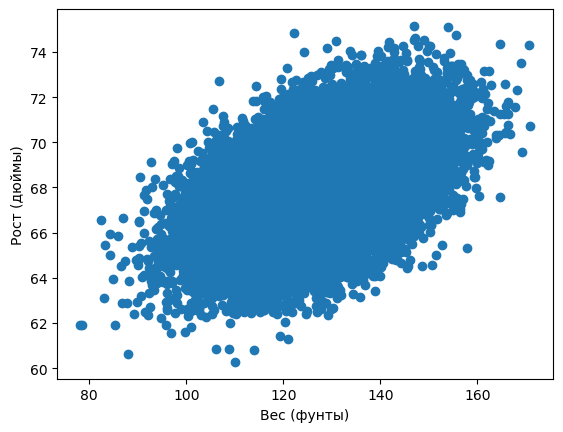

In [159]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)");

In [166]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [167]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [168]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [169]:
clf = SGDRegressor()
clf.fit(X_train_scaled, y_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.16s/it]


SGDRegressor()

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

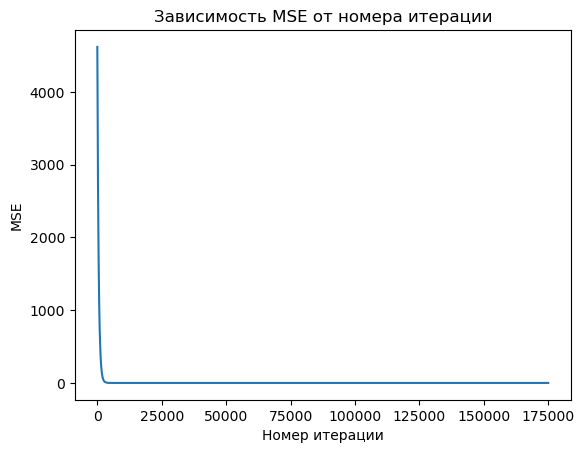

In [75]:
plt.plot(range(len(clf.mse_)), clf.mse_);
plt.xlabel("Номер итерации")
plt.ylabel("MSE")
plt.title("Зависимость MSE от номера итерации");

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [76]:
min(clf.mse_)

2.7151352406643623

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

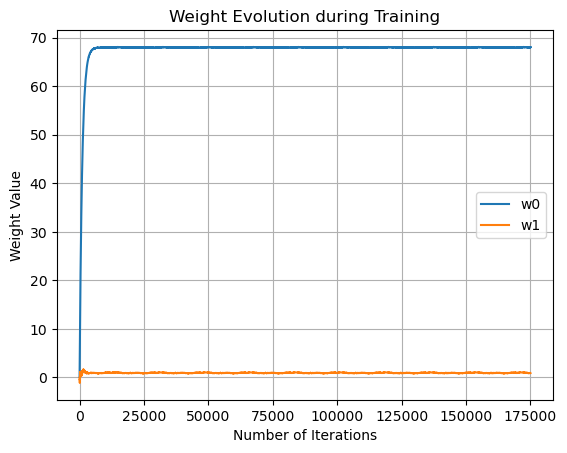

In [81]:
weights = clf.weights_
first_column = [item[0] for item in clf.weights_]
second_column = [item[1] for item in clf.weights_]

plt.plot(range(1, len(weights) + 1), first_column, label='w0')
plt.plot(range(1, len(weights) + 1), second_column, label='w1')
plt.xlabel('Number of Iterations')
plt.ylabel('Weight Value')
plt.title('Weight Evolution during Training')
plt.legend()
plt.grid(True)
plt.show()

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [82]:
pred = clf.predict(X_valid_scaled)

In [83]:
mean_squared_error(y_valid, pred)

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
lin_reg = LinearRegression()

In [86]:
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [87]:
predicted = lin_reg.predict(X_valid_scaled)

In [88]:
mean_squared_error(y_valid, predicted)

2.670830767667635

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [96]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [152]:
class SGDClassifier_(BaseEstimator):
    
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.eta = eta
        self.C = C
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        best_loss = np.inf
        w = np.ones(X.shape[1])
        
        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (
                        self.C * y[i] * X[i, j] * sigma(-y[i] * w.dot(X[i, :])) - w[j]
                    )
                w = new_w.copy()
    
                
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)
    
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
                  
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5) 
        # но могли остаться нули, если значения в pred_probs = 0.5 в точности
        signs[np.where(signs == 0)] = 1
        return signs

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [90]:
from sklearn.datasets import load_breast_cancer

In [91]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [92]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [97]:
clf = SGDClassifier(C=1, eta=1e-3, n_iter=3)
clf.fit(X_train_scaled, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


SGDClassifier(n_iter=3)

Постройте график изменения log_loss.

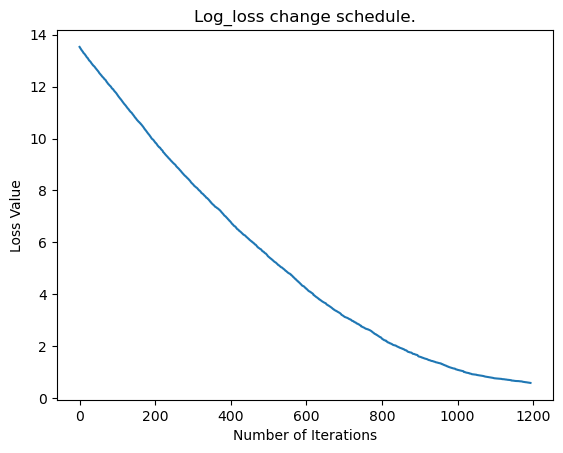

In [106]:
plt.plot(range(len(clf.loss_)),clf.loss_);
plt.xlabel('Number of Iterations')
plt.ylabel('Loss Value')
plt.title('Log_loss change schedule.')
plt.show()

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [107]:
clf = SGDClassifier(C=1000, eta=1e-3, n_iter=10)
clf.fit(X_train_scaled, y_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


SGDClassifier(C=1000)

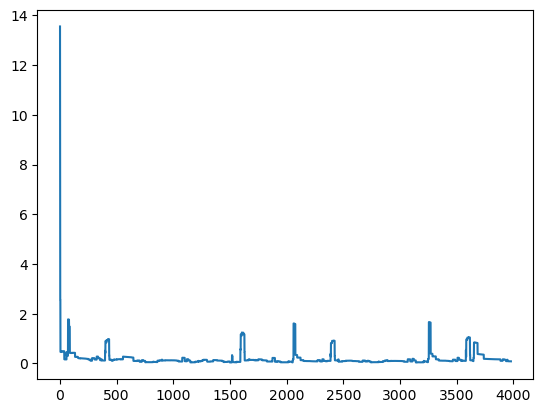

In [110]:
plt.plot(range(len(clf.loss_)), clf.loss_);

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension
 - radius error

In [121]:
pd.DataFrame({'coef_':clf.weights_[np.argmin(clf.loss_)]}, index = ['intercept'] + list(cancer.feature_names)).sort_values(by='coef_')

,coef_
radius error,-3.647785
worst texture,-3.602279
area error,-3.428575
worst area,-3.354576
worst radius,-3.089559
mean concave points,-3.047618
worst concavity,-2.834845
mean concavity,-2.816981
worst smoothness,-2.308164
worst perimeter,-1.979985


In [133]:
print(roc_auc_score(y_valid, clf.predict_proba(X_valid_scaled)[:,1]))
print(log_loss(y_valid, clf.predict_proba(X_valid_scaled)[:,1]))

0.9830104321907601
0.26714340711377726


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [134]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=17)
log_reg.fit(X_train_scaled, y_train)
pred_value = log_reg.predict(X_valid_scaled)

print(roc_auc_score(y_valid, log_reg.predict_proba(X_valid_scaled)[:,1]))
print(log_loss(y_valid, log_reg.predict_proba(X_valid_scaled)[:,1]))

0.9885245901639343
0.10855223162449651


## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [141]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
import os

In [142]:
train_reviews = load_files(os.path.join('data/aclImdb/', 'train'), categories=["pos", "neg"])

In [143]:
test_reviews = load_files(os.path.join('data/aclImdb/', 'test'),categories=["pos", "neg"])
text_test, y_test = test_reviews.data, test_reviews.target

In [144]:
text_train, y_train = train_reviews.data, train_reviews.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [145]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

Wall time: 34.1 s


In [146]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [148]:
%%time
clf = LogisticRegression(random_state=17).fit(X_train, y_train)

Wall time: 57.4 s


D:\Program files\ana3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [149]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.9577014464

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [151]:
from sklearn.linear_model import SGDClassifier

In [153]:
clf = SGDClassifier(loss='log', random_state=17, max_iter=100)

In [154]:
clf.fit(X_train, y_train)

SGDClassifier(loss='log', max_iter=100, random_state=17)

In [155]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.9519741536

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5